<a href="https://colab.research.google.com/github/Kryptera-K/WDC-Kumo-CCI-Momentum-Strategy/blob/main/WDC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "WDC"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("WDC_clean.csv", index=False)
df

/tmp/ipython-input-1289023539.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,2.382061,2.571114,2.382061,2.571114,3257094
2000-01-04,2.835789,3.024842,2.344252,2.382063,10134577
2000-01-05,2.646736,2.873599,2.495494,2.873599,5218706
2000-01-06,2.760168,2.835789,2.608926,2.722358,3265693
2000-01-07,3.402947,3.402947,2.797979,2.797979,12942909
...,...,...,...,...,...
2025-10-27,126.669998,133.100006,123.220001,133.000000,7249300
2025-10-28,124.919998,126.820000,121.849998,126.699997,7031900
2025-10-29,141.380005,145.679993,131.250000,131.429993,18267300


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

BEAR_EMA_PERIOD = 13
BEAR_POWER_LEVEL = 0
BEAR_POWER_SHIFT = 5
CCI_LEVEL = 0
CCI_PERIOD = 14
CCI_SHIFT = 5
CCI_SHIFT_2 = 10
ICHIMOKU_DISPLACEMENT = 26
ICHIMOKU_KIJUN_PERIOD = 26
ICHIMOKU_SENKOU_B_PERIOD = 52
ICHIMOKU_TENKAN_PERIOD = 9
MACD_FAST = 12
MACD_LEVEL = 1.0
MACD_SIGNAL = 9
MACD_SLOW = 26

# -------------------------
# Indicator Functions
# -------------------------

def kumo_breakout_bullish(df):
    df = calculate_ichimoku(df)
    return df['Close'] > df[['senkou_span_a', 'senkou_span_b']].max(axis=1)


def calculate_ichimoku(df, tenkan_period=ICHIMOKU_TENKAN_PERIOD, kijun_period=ICHIMOKU_KIJUN_PERIOD, senkou_b_period=ICHIMOKU_SENKOU_B_PERIOD, displacement=ICHIMOKU_DISPLACEMENT):
    df = df.copy()

    # Lines
    df['tenkan_sen'] = (df['High'].rolling(tenkan_period).max() + df['Low'].rolling(tenkan_period).min()) / 2
    df['kijun_sen'] = (df['High'].rolling(kijun_period).max() + df['Low'].rolling(kijun_period).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(displacement)
    df['senkou_span_b'] = ((df['High'].rolling(senkou_b_period).max() + df['Low'].rolling(senkou_b_period).min()) / 2).shift(displacement)
    df['chikou_span'] = df['Close'].shift(-displacement)

    return df


def cci_change_up(df, period=CCI_PERIOD, shifts=CCI_SHIFT, shift_2=CCI_SHIFT_2):
    df['CCI_main'] = calculate_cci(df, period)['CCI']
    return (df['CCI_main'] > df['CCI_main'].shift(shifts)) & \
           (df['CCI_main'].shift(shifts) <= df['CCI_main'].shift(shift_2))


def calculate_cci(df, period=CCI_PERIOD):
    """
    Calculate Commodity Channel Index (CCI).
    """
    df = df.copy()
    # Typical Price
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    # SMA of TP
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    # Mean Deviation
    df['MeanDev'] = df['TP'].rolling(period).apply(
        lambda x: np.mean(np.abs(x - np.mean(x))), raw=True
    )
    # CCI
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df


def macd_cross_above_signal(df):
    df = calculate_macd(df)
    return (df["MACD_prev"] <= df["Signal_prev"]) & (df["MACD"] > df["Signal"])


def calculate_macd(df, fast=MACD_FAST, slow=MACD_SLOW, signal=MACD_SIGNAL):
    """
    Calculate MACD and Signal lines.
    """
    df = df.copy()
    df["EMA_fast"] = df["Close"].ewm(span=fast, adjust=False).mean()
    df["EMA_slow"] = df["Close"].ewm(span=slow, adjust=False).mean()
    df["MACD"] = df["EMA_fast"] - df["EMA_slow"]
    df["Signal"] = df["MACD"].ewm(span=signal, adjust=False).mean()

    # Previous values for comparisons
    df["MACD_prev"] = df["MACD"].shift(1)
    df["Signal_prev"] = df["Signal"].shift(1)

    return df


def bears_power_higher_than(df, period = BEAR_EMA_PERIOD, level=BEAR_POWER_LEVEL):
    df = calculate_bears_power(df, period)
    return df['Bears_Power'] > level


def calculate_bears_power(df, period=BEAR_EMA_PERIOD):
    """Calculate Bears Power indicator and return updated DataFrame"""
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    df['Bears_Power'] = df['Low'] - df['EMA']
    return df



# -------------------------
# Entry conditions
# -------------------------

df["Ichimoku_Kumo_Breakout_Bullish"] = kumo_breakout_bullish(df)
df["CCI_Change_Up"] = cci_change_up(df)

# -------------------------
# Exit conditions
# -------------------------

df["MACD_cross_above_signal"] = macd_cross_above_signal(df)
df["BearP_Higher_0"] = bears_power_higher_than(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'Ichimoku_Kumo_Breakout_Bullish',
    'CCI_Change_Up',
]
exit_conditions = [
    'MACD_cross_above_signal',
    'BearP_Higher_0',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                2000-01-03 00:00:00
End                                  2025-10-31 00:00:00
Period                                6498 days 00:00:00
Start Value                                     100000.0
End Value                                12351944.155449
Total Return [%]                            12251.944155
Benchmark Return [%]                         5947.961659
Max Gross Exposure [%]                             100.0
Total Fees Paid                            237482.384861
Max Drawdown [%]                               76.649804
Max Drawdown Duration                 1357 days 00:00:00
Total Trades                                          53
Total Closed Trades                                   53
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   69.811321
Best Trade [%]                                184.156824
Worst Trade [%]                

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-10-31 00:00:00
Period                         6498 days 00:00:00
Start Value                              100000.0
End Value                          6047961.659248
Total Return [%]                      5947.961659
Benchmark Return [%]                  5947.961659
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        76.579707
Max Drawdown Duration          1851 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                     5947961.659248
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-2703415658.py:14: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


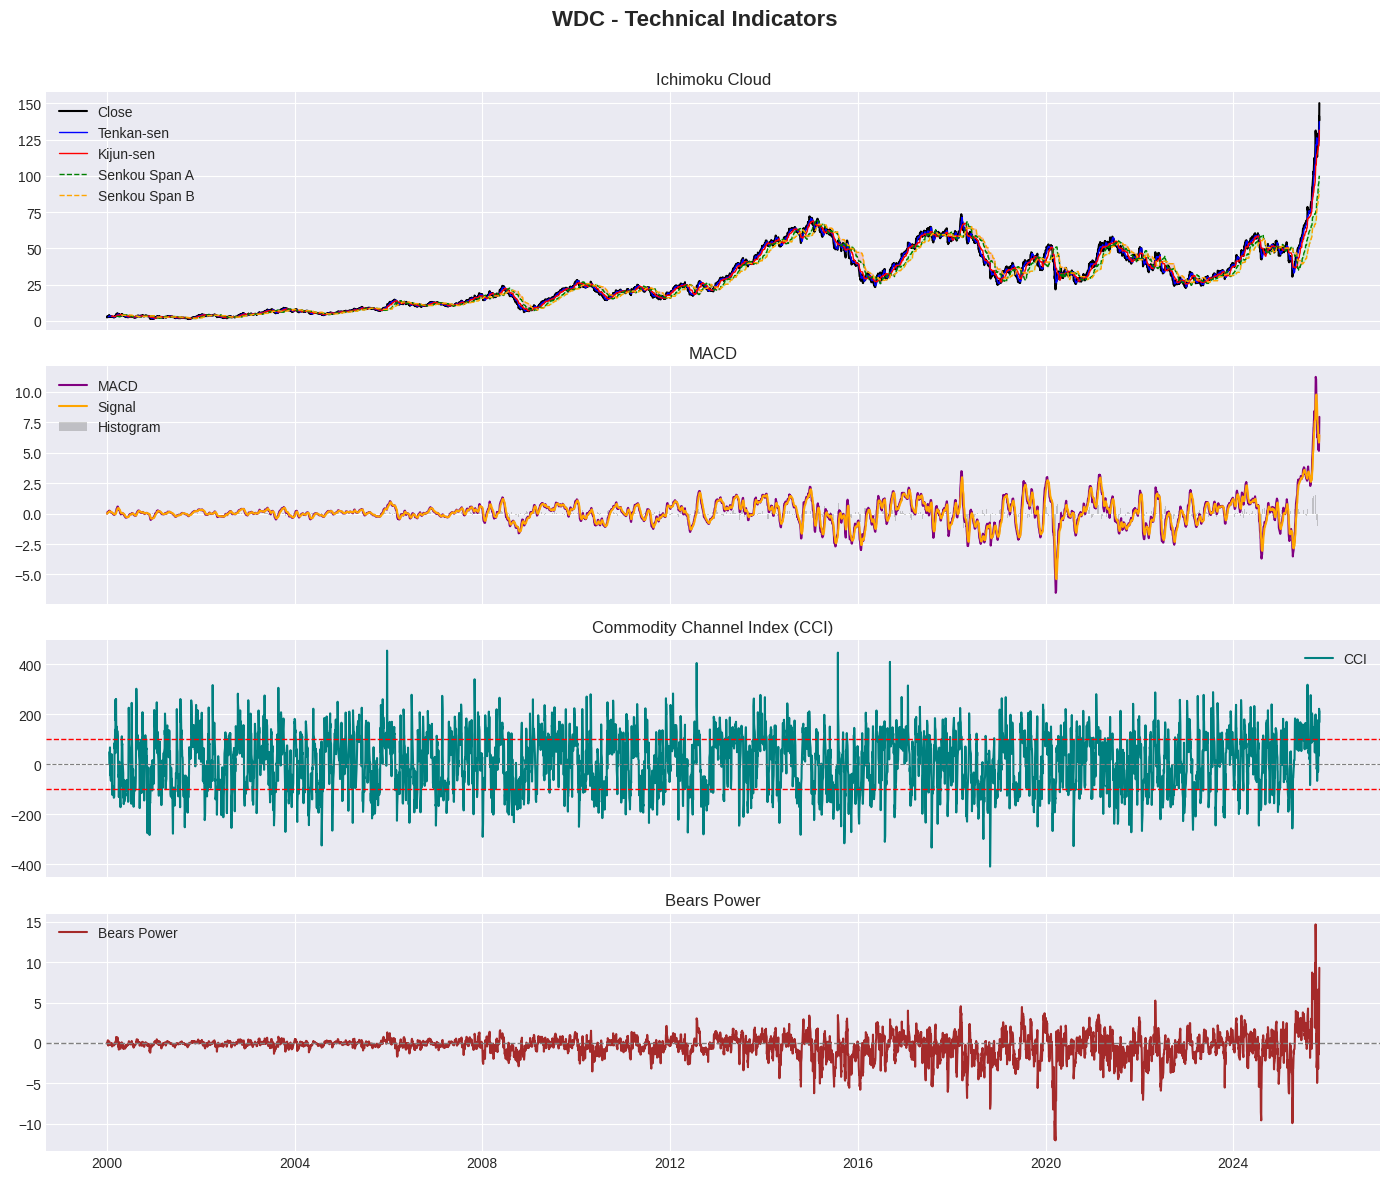

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------
symbol = "WDC"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.dropna(inplace=True)

# -------------------------
# Necessary Parameters
# -------------------------
BEAR_EMA_PERIOD = 13
BEAR_POWER_LEVEL = 0
CCI_PERIOD = 14
ICHIMOKU_DISPLACEMENT = 26
ICHIMOKU_KIJUN_PERIOD = 26
ICHIMOKU_SENKOU_B_PERIOD = 52
ICHIMOKU_TENKAN_PERIOD = 9
MACD_FAST = 12
MACD_SIGNAL = 9
MACD_SLOW = 26

# -------------------------
# Indicator Calculations
# -------------------------
def calculate_ichimoku(df, tenkan_period=ICHIMOKU_TENKAN_PERIOD, kijun_period=ICHIMOKU_KIJUN_PERIOD, senkou_b_period=ICHIMOKU_SENKOU_B_PERIOD, displacement=ICHIMOKU_DISPLACEMENT):
    df = df.copy()
    df['tenkan_sen'] = (df['High'].rolling(tenkan_period).max() + df['Low'].rolling(tenkan_period).min()) / 2
    df['kijun_sen'] = (df['High'].rolling(kijun_period).max() + df['Low'].rolling(kijun_period).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(displacement)
    df['senkou_span_b'] = ((df['High'].rolling(senkou_b_period).max() + df['Low'].rolling(senkou_b_period).min()) / 2).shift(displacement)
    df['chikou_span'] = df['Close'].shift(-displacement)
    return df

def calculate_macd(df, fast=MACD_FAST, slow=MACD_SLOW, signal=MACD_SIGNAL):
    df = df.copy()
    df["EMA_fast"] = df["Close"].ewm(span=fast, adjust=False).mean()
    df["EMA_slow"] = df["Close"].ewm(span=slow, adjust=False).mean()
    df["MACD"] = df["EMA_fast"] - df["EMA_slow"]
    df["Signal"] = df["MACD"].ewm(span=signal, adjust=False).mean()
    return df

def calculate_cci(df, period=CCI_PERIOD):
    df = df.copy()
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    df['MeanDev'] = df['TP'].rolling(period).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df

def calculate_bears_power(df, period=BEAR_EMA_PERIOD):
    df = df.copy()
    df['EMA'] = df['Close'].ewm(span=period, adjust=False).mean()
    df['Bears_Power'] = df['Low'] - df['EMA']
    return df

# Apply calculations
df = calculate_ichimoku(df)
df = calculate_macd(df)
df = calculate_cci(df)
df = calculate_bears_power(df)

# -------------------------
# Plotting
# -------------------------
plt.style.use('seaborn-v0_8-darkgrid')
fig, axs = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f'{symbol} - Technical Indicators', fontsize=16, fontweight='bold')

# 1️⃣ Ichimoku Cloud
axs[0].plot(df.index, df['Close'], label='Close', color='black')
axs[0].plot(df.index, df['tenkan_sen'], label='Tenkan-sen', color='blue', linewidth=1)
axs[0].plot(df.index, df['kijun_sen'], label='Kijun-sen', color='red', linewidth=1)
axs[0].plot(df.index, df['senkou_span_a'], label='Senkou Span A', color='green', linestyle='--', linewidth=1)
axs[0].plot(df.index, df['senkou_span_b'], label='Senkou Span B', color='orange', linestyle='--', linewidth=1)
axs[0].fill_between(df.index, df['senkou_span_a'], df['senkou_span_b'],
                    where=df['senkou_span_a'] >= df['senkou_span_b'],
                    color='lightgreen', alpha=0.3)
axs[0].fill_between(df.index, df['senkou_span_a'], df['senkou_span_b'],
                    where=df['senkou_span_a'] < df['senkou_span_b'],
                    color='lightcoral', alpha=0.3)
axs[0].set_title("Ichimoku Cloud")
axs[0].legend()

# 2️⃣ MACD
axs[1].plot(df.index, df['MACD'], label='MACD', color='purple')
axs[1].plot(df.index, df['Signal'], label='Signal', color='orange')
axs[1].bar(df.index, df['MACD'] - df['Signal'], label='Histogram', color='gray', alpha=0.4)
axs[1].set_title("MACD")
axs[1].legend()

# 3️⃣ CCI
axs[2].plot(df.index, df['CCI'], label='CCI', color='teal')
axs[2].axhline(100, color='red', linestyle='--', linewidth=1)
axs[2].axhline(-100, color='red', linestyle='--', linewidth=1)
axs[2].axhline(0, color='gray', linestyle='--', linewidth=0.8)
axs[2].set_title("Commodity Channel Index (CCI)")
axs[2].legend()

# 4️⃣ Bears Power
axs[3].plot(df.index, df['Bears_Power'], label='Bears Power', color='brown')
axs[3].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[3].set_title("Bears Power")
axs[3].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
